# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В распоряжении набор данных с разметкой о токсичности правок. Необходимо обучить модель, которая будет классифицировать комментарии на позитивные и негативные. 

В ходе работы будем исопльзовать классические модели а также попробуем toxic-BERT.

**Описание данных**

Столбец `text` содержит текст комментария, а `toxic` — целевой признак.

## Подготовка

Устанавливаем пакеты

In [195]:
def check_if_installed(packages):
    for package in packages:
        try:
            exec(f'import {package}')
        except Exception as ex:
            print(ex)
            !pip install {package}

In [196]:
libs = [
    '-q spacy',
    'catboost'
]

check_if_installed(libs)
#!spacy download

invalid syntax (<string>, line 1)


Импортируем пакеты

In [197]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import spacy
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve


In [198]:
BASE_DIR = os.getcwd()

pth1 = f'{BASE_DIR}\datasets\\toxic_comments.csv'
df = pd.read_csv(pth1)


Первичный анализ исходных данных

In [199]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Мы можем удалить столбец `Unnamed: 0` за избыточностью, также заменим тип данных `int64` на `int8`

In [201]:
df = df.drop('Unnamed: 0', axis=1)
df['toxic'] = df['toxic'].astype('int8')

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 1.4+ MB


Проверка на дубликаты

In [203]:
df.duplicated().sum()

0

Разделим выборку. Т.к. мы будем использовать кросс-валидацию разделим на обучающую и тестовую

In [204]:
train, test = train_test_split(df, test_size=0.2)

target_train = train['toxic']
features_train = train.drop('toxic', axis=1)

target_test = test['toxic']
features_test = test.drop('toxic', axis=1)

Проведём лемматизацию

In [205]:
nlp = spacy.load('en_core_web_sm')

In [206]:
def lemmatizer(text):
    text = re.sub(r"[^a-zA-Z\']", ' ', text)
    doc = nlp(text)
    joined = " ".join([token.lemma_ for token in doc])
    final = re.sub(r'\s{2,}', ' ' , joined)
    return final

In [207]:
features_train['text'] = features_train['text'].apply(lemmatizer)
features_test['text'] = features_test['text'].apply(lemmatizer)

На этапе предобработки были проведены следующие действия:
- удалён лишний признак;
- выборка разделена на обучающую и тестовую;  
- проведена лемматизация корпуса текстов;

## Обучение

### Logistic Regression

In [208]:
cv = StratifiedKFold(n_splits=4)

In [209]:
parameters_lr = []

pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('regressor', LogisticRegression(max_iter=1000))
])

params = {'regressor__C':[12]}

grid_lr = GridSearchCV(
    pipe,
    param_grid=params, 
    scoring='f1', 
    n_jobs=-1, 
    cv=cv,
)

grid_lr.fit(features_train['text'], target_train)

parameters_lr.append({
    'estimator_params' : grid_lr.best_params_,
    'f1' : grid_lr.best_score_,
})

### Decision Tree

In [210]:
parameters_dt = []

pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('regressor', DecisionTreeClassifier())
])

params = {
    'regressor__max_depth': [19]
}

grid = GridSearchCV(
    pipe,
    param_grid=params, 
    scoring='f1', 
    n_jobs=-1, 
    cv=cv,
)

grid.fit(features_train['text'], target_train)

parameters_dt.append({
    'estimator_params' : grid.best_params_,
    'f1' : grid.best_score_,
})

### Random Forest

In [211]:
parameters_rf = []

pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('regressor', RandomForestClassifier())
])

params = {
    'regressor__max_depth': [29],
    'regressor__n_estimators': [180],
}

grid = GridSearchCV(
    pipe,
    param_grid=params, 
    scoring='f1', 
    n_jobs=-1, 
    cv=cv,
)

grid.fit(features_train['text'], target_train)

parameters_rf.append({
    'estimator_params' : grid.best_params_,
    'f1' : grid.best_score_,
})

### CatBoost

In [212]:
parameters_cb = []

pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('regressor', CatBoostClassifier(
        random_seed=1, 
        iterations=1000,  
        verbose=200,
    ))
])


params = {
    'regressor__depth': [5],
}

grid = GridSearchCV(
    pipe,
    param_grid=params, 
    scoring='f1', 
    n_jobs=-1, 
    cv=cv,
)

grid.fit(features_train['text'], target_train)

parameters_cb.append({
    'estimator_params' : grid.best_params_,
    'f1' : grid.best_score_,
})

Learning rate set to 0.081637
0:	learn: 0.6110570	total: 526ms	remaining: 8m 45s
200:	learn: 0.1454030	total: 1m 36s	remaining: 6m 23s
400:	learn: 0.1244679	total: 3m 14s	remaining: 4m 50s
600:	learn: 0.1133859	total: 4m 50s	remaining: 3m 12s
800:	learn: 0.1061441	total: 6m 25s	remaining: 1m 35s
999:	learn: 0.1003109	total: 8m	remaining: 0us


In [213]:
pd.DataFrame.from_dict([parameters_lr[0], parameters_dt[0], parameters_rf[0], parameters_cb[0]])

,estimator_params,f1
0,{'regressor__C': 12},0.784735
1,{'regressor__max_depth': 19},0.649403
2,"{'regressor__max_depth': 29, 'regressor__n_est...",0.012385
3,{'regressor__depth': 5},0.760197


Лучшая модель LogisticRegression с результатом f1 = 0.78, проверим её на тестовой выборке

## Тестирование

In [214]:
predict = grid_lr.predict(features_test['text'])
print(f1_score(target_test, predict))

0.7826996860830138


На этапе обучения моделей методом GridSearcCV были обучены четыре различные модели:  
LogisticRegression, DectisionTreeClassifier, RandomForestClassifier, CatBoost.  

Данные для сравнения по целевой метрике F1 приведены в таблице.  
Лучшая модель LogisticRegression с результатом на кросс-валидации f1 = 0.78.  
На тестовой выборке LogisticRegression показала результат f1 = 0.80.

На первом этапе была предобработана исходная выборка и проведена лемматизация.  
На этапе обучения моделей методом GridSearcCV были обучены четыре различные модели.  
Лучший результат показала модель LogisticRegression: C=12;  
Результат на кросс-валидации f1 = 0.78, на тестовой выборке f1 = 0.80.  
Среди моделей классического ML лидирующее место занимает логистическая регрессия, теперь посмотрим какой результат покажет toxic-BERT

## Toxic-BERT 🤗

Проверим установку необходимых пакетов

In [215]:
libs = [
    'torch',
    'transformers'
]

check_if_installed(libs)

In [216]:
import torch
from detoxify import Detoxify

Выбираем модель `toxic_bert`

In [217]:
model = torch.hub.load('unitaryai/detoxify','toxic_bert')

Using cache found in C:\Users\PC/.cache\torch\hub\unitaryai_detoxify_master


In [220]:
features_test_list = features_test['text'].to_list()
target_test_list = target_test.to_list()

In [221]:
#т.к. данные не помещаются в оперативную память целиком будем обрабатывать их батчами
batch_size=100

all_predictions = []

for i in range(0, len(features_test_list), batch_size):
    batch_text = features_test_list[i:i+batch_size]
    predict_batch = Detoxify('original').predict(batch_text)
    all_predictions.extend(predict_batch['toxicity'])

prediction = pd.DataFrame(all_predictions, index=range(len(features_test_list)))

Оценим ROC кривую

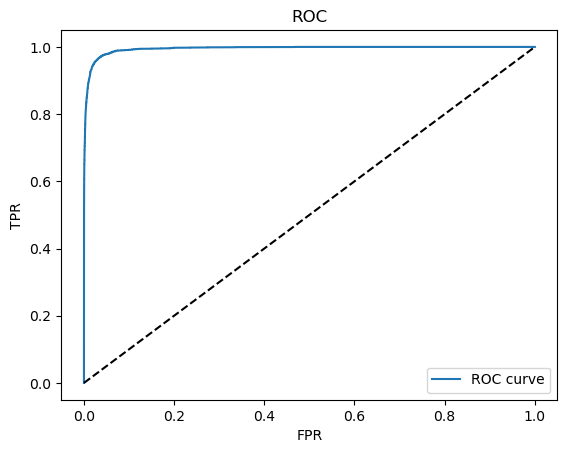

In [224]:
fpr, tpr, thresholds = roc_curve(target_test_list, prediction)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

Найдём оптимальное пороговое значение

In [225]:
# Находим индекс точки на графике, ближайшей к верхнему левому углу
index = np.argmax(np.abs(tpr - fpr))
# Определяем пороговое значение, соответствующее этой точке
threshold = thresholds[index]

print("Оптимальное пороговое значение:", threshold)

Оптимальное пороговое значение: 0.1551182121038437


Преобразуем вероятности в бинарные классы на основе выбранного порогового значения

In [228]:
target_predicted = [1 if x > threshold else 0 for x in prediction[0].values.tolist()]

f1 = f1_score(target_test_list, target_predicted)

print(f"F1-score: {f1}")

F1-score: 0.8390758005674909


## Выводы

`Toxic-BERT` из коробки, без дообучения, показал `f1 = 0.84`, тогда как из классических моделей лучший результат показала `LogisticRegression` с результатом на тестовой выборке `f1 = 0.80`.  Если нет строгих требований по времени то мы можем использовать `toxic-BERT`, в противном случае стоит выбрать `LogisticRegression`